# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
df = pd.read_csv(url, names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                             'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num'] != 0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [3]:
def bivariate_analysis(df, response_var, explanatory_var):
    df['flag_doente'] = (df[response_var] != 0).astype('int64')
    value_counts = df['flag_doente'].value_counts()
    doentes = value_counts.get(1)
    saudaveis = value_counts.get(0)
    total = len(df)

    if saudaveis != 0:
        media_doentes = doentes / total
        odds = doentes / saudaveis
        odds_ratio = odds / (1 - odds)
        logito, woe = np.log(odds), np.log(odds_ratio)
    else:
        media_doentes, odds, odds_ratio, logito, woe = np.nan, np.nan, np.nan, np.nan, np.nan

    table = PrettyTable()
    table.field_names = ["Estatística", "Valor"]
    table.add_row(["Número de saudáveis", saudaveis])
    table.add_row(["Número de doentes", doentes])
    table.add_row(["Total", total])
    table.add_row(["Quantidade média de doentes", f"{media_doentes:.2%}"])
    table.add_row(["Odds", f"{odds:.4f}"])
    table.add_row(["Odds ratio", f"{odds_ratio:.4f}"])
    table.add_row(["Logito", f"{logito:.4f}"])
    table.add_row(["Weight of Evidence (WOE)", f"{woe:.4f}"])
    print(table)
bivariate_analysis(df, 'num', 'sex')

+-----------------------------+---------+
|         Estatística         |  Valor  |
+-----------------------------+---------+
|     Número de saudáveis     |   164   |
|      Número de doentes      |   139   |
|            Total            |   303   |
| Quantidade média de doentes |  45.87% |
|             Odds            |  0.8476 |
|          Odds ratio         |  5.5600 |
|            Logito           | -0.1654 |
|   Weight of Evidence (WOE)  |  1.7156 |
+-----------------------------+---------+


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [4]:
def categorize_continuous_variable(df, variable, num_categories=5):
    df[f'{variable}_group'] = pd.cut(df[variable], bins=num_categories)
    bivariate_var = df.groupby(f'{variable}_group', observed=False)['flag_doente'].agg(['count', 'sum', 'mean', 'min', 'max'])
    table = PrettyTable()
    table.field_names = ["Category", "Count", "Sum", "Mean", "Min", "Max"]

    for index, row in bivariate_var.iterrows():
        table.add_row([index, *row])
    print(table)
categorize_continuous_variable(df, 'age', num_categories=5)

+----------------+-------+------+---------------------+-----+-----+
|    Category    | Count | Sum  |         Mean        | Min | Max |
+----------------+-------+------+---------------------+-----+-----+
| (28.952, 38.6] |  11.0 | 3.0  |  0.2727272727272727 | 0.0 | 1.0 |
|  (38.6, 48.2]  |  71.0 | 21.0 | 0.29577464788732394 | 0.0 | 1.0 |
|  (48.2, 57.8]  |  97.0 | 41.0 |  0.422680412371134  | 0.0 | 1.0 |
|  (57.8, 67.4]  | 107.0 | 67.0 |  0.6261682242990654 | 0.0 | 1.0 |
|  (67.4, 77.0]  |  17.0 | 7.0  |  0.4117647058823529 | 0.0 | 1.0 |
+----------------+-------+------+---------------------+-----+-----+


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [5]:
def fit_logistic_regression(df, predictors, response):
    result = sm.Logit(df[response], sm.add_constant(df[predictors])).fit()
    print(result.summary())
    return result

predictors = ['sex', 'cp', 'trestbps', 'age']
response_variable = 'flag_doente'
result_logistic = fit_logistic_regression(df, predictors, response_variable)

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Wed, 27 Dec 2023   Pseudo R-squ.:                  0.2605
Time:                        19:41:49   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

                 predicted_prob  flag_doente
predicted_group                             
(0.0119, 0.146]        0.076255     0.098361
(0.146, 0.349]         0.249060     0.183333
(0.349, 0.575]         0.457982     0.491803
(0.575, 0.772]         0.673059     0.683333
(0.772, 0.928]         0.837449     0.836066


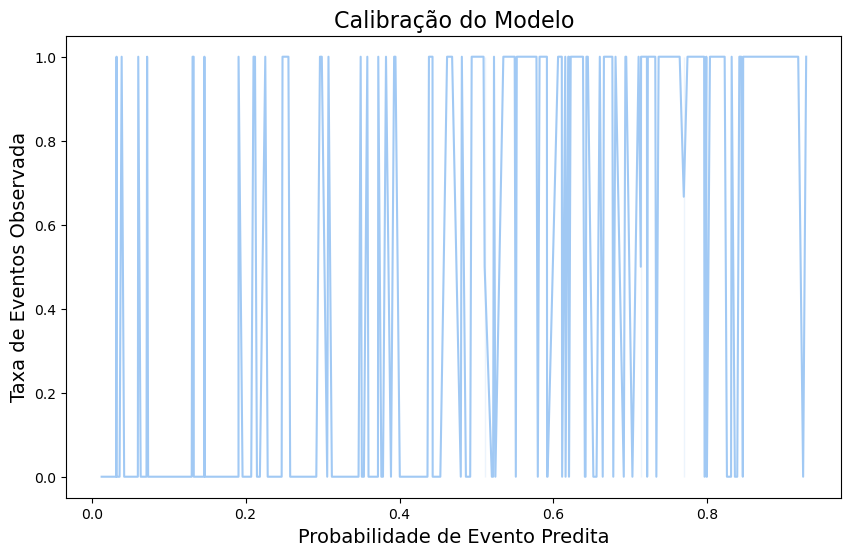

In [6]:
df['predicted_prob'] = result_logistic.predict(sm.add_constant(df[predictors]))
df['predicted_group'] = pd.qcut(df['predicted_prob'], q=5)
calibration_results = df.groupby('predicted_group', observed=False)[['predicted_prob', 'flag_doente']].mean()
print(calibration_results)

sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
sns.lineplot(x='predicted_prob', y='flag_doente', data=df)
plt.ylabel('Taxa de Eventos Observada', fontsize=14)
plt.xlabel('Probabilidade de Evento Predita', fontsize=14)
plt.title('Calibração do Modelo', fontsize=16)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [7]:
y_pred = result_logistic.predict(sm.add_constant(df[predictors])) > 0.5

accuracy = accuracy_score(df[response_variable], y_pred)
roc_auc = roc_auc_score(df[response_variable], y_pred)
gini = 2 * float(roc_auc) - 1
fpr, tpr, thresholds = roc_curve(df[response_variable], y_pred)
ks = max(tpr - fpr)
print(f"Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}, GINI: {gini:.4f}, KS: {ks:.4f}")

Accuracy: 0.7789, AUC: 0.7776, GINI: 0.5553, KS: 0.5553


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.455126
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Wed, 27 Dec 2023   Pseudo R-squ.:                  0.3401
Time:                        19:42:24   Log-Likelihood:                -137.90
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 3.666e-26
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 105.5911    141.912      0.744      0.457    -172.551     383.734
se

c:\Users\Arthu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Arthu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


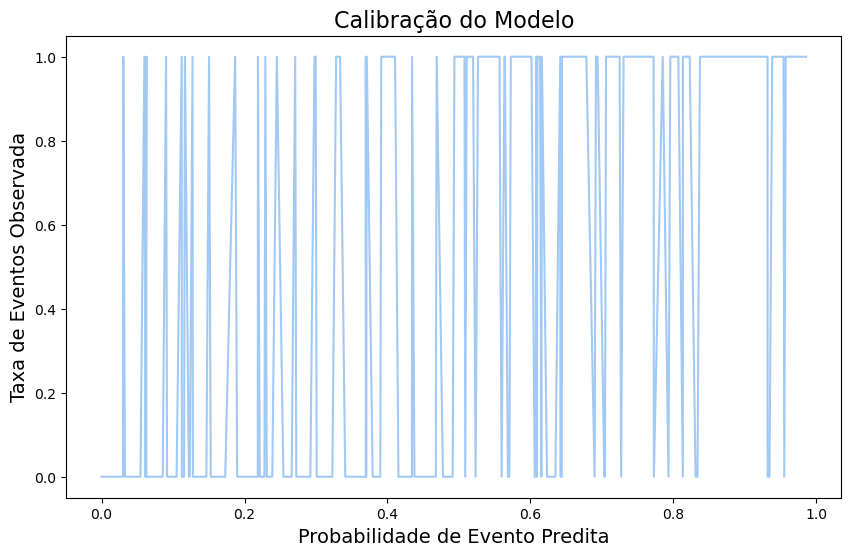

Updated XGBoost Accuracy: 0.8944, AUC: 0.8959, GINI: 0.7917, KS: 0.7917


In [8]:
def fit_logistic_regression(df, predictors, response):
    X = sm.add_constant(df[predictors])
    X['age_sex_interaction'] = X['age'] * X['sex']
    result = sm.Logit(df[response], X).fit()
    print(result.summary())
    return result

predictors = ['sex', 'cp', 'trestbps', 'age', 'thalach']
response_variable = 'flag_doente'
df['age_squared'] = df['age']**2
df['age_sex_squared'] = df['age']**2 * df['sex']
df['age_log'] = np.log(df['age'] + 1)
predictors += ['age_squared', 'age_sex_squared', 'age_log']
result_updated = fit_logistic_regression(df, predictors, response_variable)
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, random_state=42)

param_grid = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [5, 10, 15]}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(df[predictors], df[response_variable])
best_xgb_model = grid_search.best_estimator_
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=predictors)
print("Feature Importances:")
print(feature_importances)

cross_val_accuracy_xgb = cross_val_score(best_xgb_model, df[predictors], df[response_variable], cv=10, scoring='accuracy').mean()
print(f"Cross-validated XGBoost Accuracy: {cross_val_accuracy_xgb:.4f}")
df['age_sex_interaction'] = df['age'] * df['sex']
df['predicted_prob'] = result_updated.predict(sm.add_constant(df[predictors + ['age_sex_interaction']]))
df['predicted_group'] = pd.qcut(df['predicted_prob'], q=5)
calibration_results = df.groupby('predicted_group', observed=False)[['predicted_prob', 'flag_doente']].mean()
print(calibration_results)
sns.set_palette("pastel")
plt.figure(figsize=(10, 6))
sns.lineplot(x='predicted_prob', y='flag_doente', data=df)
plt.ylabel('Taxa de Eventos Observada', fontsize=14)
plt.xlabel('Probabilidade de Evento Predita', fontsize=14)
plt.title('Calibração do Modelo', fontsize=16)
plt.show()

y_pred_xgb = best_xgb_model.predict(df[predictors]) > 0.5
accuracy_updated_xgb = accuracy_score(df[response_variable], y_pred_xgb)
roc_auc_updated_xgb = roc_auc_score(df[response_variable], y_pred_xgb)
gini_updated_xgb = 2 * float(roc_auc_updated_xgb) - 1
fpr_updated_xgb, tpr_updated_xgb, thresholds_updated_xgb = roc_curve(df[response_variable], y_pred_xgb)
ks_updated_xgb = max(tpr_updated_xgb - fpr_updated_xgb)
print(f"Updated XGBoost Accuracy: {accuracy_updated_xgb:.4f}, AUC: {roc_auc_updated_xgb:.4f}, GINI: {gini_updated_xgb:.4f}, KS: {ks_updated_xgb:.4f}")